## Florence-2
**Florence-2 is an advanced vision foundation model that uses a prompt-based approach to handle a wide range of vision and vision-language tasks. Florence-2 can interpret simple text prompts to perform tasks like captioning, object detection, and segmentation. It leverages our FLD-5B dataset, containing 5.4 billion annotations across 126 million images, to master multi-task learning. The model's sequence-to-sequence architecture enables it to excel in both zero-shot and fine-tuned settings, proving to be a competitive vision foundation model.**

In [1]:
%pip install transformers
%pip install torch
%pip install timm
%pip install flash_attn
%pip install einops

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import copy
import datetime
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import sys
import torch

from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM
%matplotlib inline

## Loading the Model

In [3]:
model_id = 'microsoft/Florence-2-large'

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Helper Functions

In [4]:
def florence2(task_prompt, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return parsed_answer

In [5]:
def plot_bbox(image, data):
    """
    Plot BBox
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(image)

    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=2,
                                 edgecolor='lime',
                                 facecolor='none')
        ax.add_patch(rect)
        plt.text(x1,
                 y1,
                 label,
                 color='black',
                 fontsize=8,
                 bbox=dict(facecolor='lime', alpha=1))

    ax.axis('off')
    plt.show()

In [6]:
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    draw = ImageDraw.Draw(image)
    scale = 1

    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = "lime"
        fill_color = "lime" if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    display(image)

In [7]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.
    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.
    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    od_results = {'bboxes': bboxes, 'labels': labels}

    return od_results

In [8]:
def draw_ocr_bboxes(image, prediction):
    """
    Draw OCR BBox
    """
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']

    for box, label in zip(bboxes, labels):
        color = 'lime'
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=4, outline=color)
        draw.text((new_box[0] + 8, new_box[1] + 2),
                  "{}".format(label),
                  align="right",
                  fill=color)

    display(image)

## Image

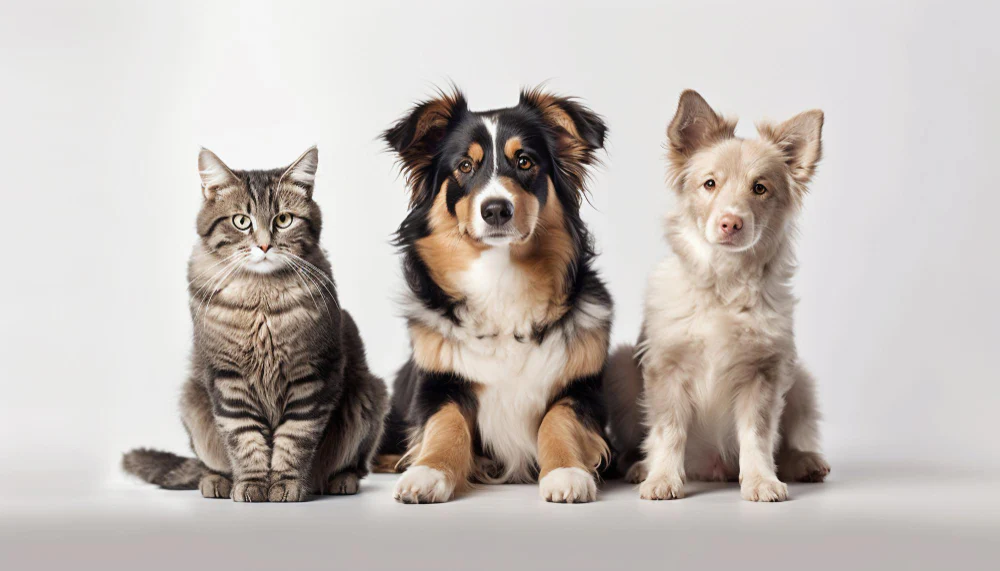

In [9]:
url = "https://github.com/RohanVolety/florence-2-sam-2/blob/main/cats.jpg?raw=true"

image = Image.open(requests.get(url, stream=True).raw)
image

In [10]:
task_prompt = '<OD>'

results = florence2(task_prompt)
print("\033[1;31;34m")
print(results)


{'<OD>': {'bboxes': [[117.5, 144.7484893798828, 394.5, 504.4784851074219], [371.5, 78.51249694824219, 620.5, 505.6204833984375], [624.5, 88.21949768066406, 833.5, 503.33648681640625]], 'labels': ['cat', 'dog', 'dog']}}


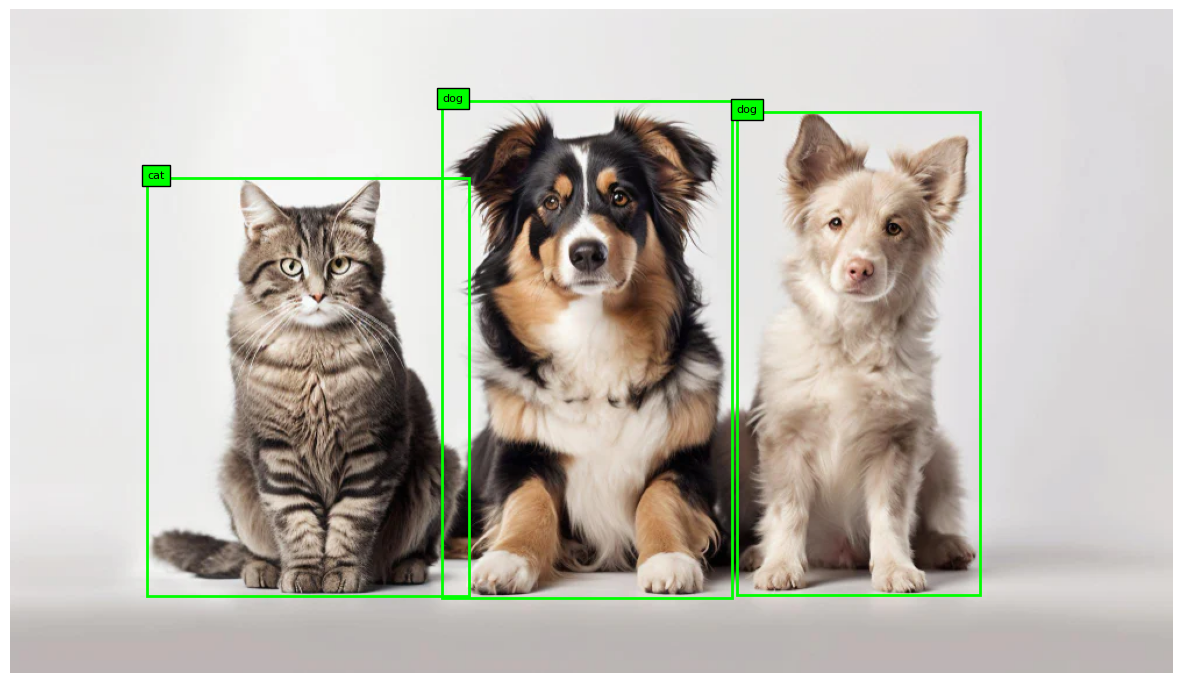

In [11]:
plot_bbox(image, results['<OD>'])

## **Now using SAM-2 with Florence-2 Model**
Segment Anything Model 2 (SAM 2) is a foundation model towards solving promptable visual segmentation in images and videos. Meta extend SAM to video by considering images as a video with a single frame. The model design is a simple transformer architecture with streaming memory for real-time video processing.

Here we will take output(bbox coordinates) from Florence model and feed it the SAM model which will segment the image.

In [12]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [13]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 510 (delta 152), reused 68 (delta 68), pack-reused 304 (from 1)
Receiving objects: 100% (510/510), 88.45 MiB | 22.94 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
 

In [6]:
# !pip install -q supervision[assets] jupyter_bbox_widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 968.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.8 MB/s eta 0:00:00


In [14]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [16]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [17]:
!mkdir -p {HOME}/checkpoints
# # !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# # !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# # !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [19]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Initialize SAM2 model
checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build and load SAM2 model
sam2_model = build_sam2(model_cfg, checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

# Read and prepare the image
image_path = 'https://github.com/RohanVolety/florence-2-sam-2/blob/main/cats.jpg?raw=true'
image = Image.open(requests.get(url, stream=True).raw)
predictor.set_image(image)

In [20]:
results['<OD>']['bboxes']

[[117.5, 144.7484893798828, 394.5, 504.4784851074219],
 [371.5, 78.51249694824219, 620.5, 505.6204833984375],
 [624.5, 88.21949768066406, 833.5, 503.33648681640625]]

In [21]:
florence2_bboxes = results['<OD>']['bboxes']

all_boxes = []

for bbox in florence2_bboxes:
    all_boxes.append(bbox)

print(all_boxes)


[[117.5, 144.7484893798828, 394.5, 504.4784851074219], [371.5, 78.51249694824219, 620.5, 505.6204833984375], [624.5, 88.21949768066406, 833.5, 503.33648681640625]]


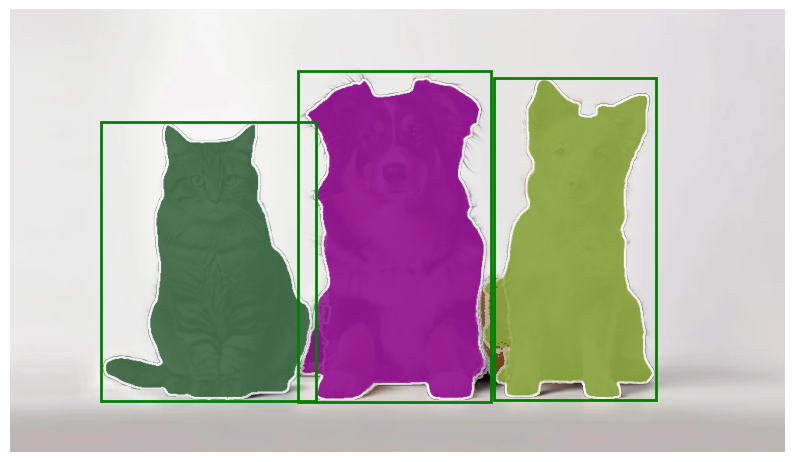

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

for bbox in all_boxes:
    input_box = np.array(bbox)
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True
    )
    # Display each mask
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    show_box(input_box, plt.gca())

plt.axis('off')
plt.show()


